```
pip install pandas matplotlib
```

In [1]:
import json
import os
from time import perf_counter

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from subwabbit import VowpalWabbitBaseFormatter, VowpalWabbitProcess, VowpalWabbitNonBlockingProcess


PREDICTION_TIMEOUT = 0.01


class BenchmarkFormatter(VowpalWabbitBaseFormatter):

    def format_common_features(self, common_features, debug_info=None):
        return ' '.join([
            '|d {}'.format(' '.join('d{}:{:.2f}'.format(k, v) for k, v in common_features['d'].items())),
            '|e {}'.format(' '.join('e{}:{:.2f}'.format(k, v) for k, v in common_features['e'].items())),
            '|f {}'.format(' '.join('f{}'.format(f) for f in common_features['f'])),
            '|g {}'.format(' '.join('g{}:{:.2f}'.format(k, v) for k, v in common_features['g'].items())),
            '|h h{}'.format(common_features['h']),
            '|i i{}'.format(common_features['i'])
        ])

    def format_item_features(self, common_features, item_features, debug_info=None):
        return ' '.join([
            '|a a{}'.format(item_features['a']),
            '|b b{}'.format(item_features['b']),
            '|c {}'.format(' '.join('c{}'.format(c) for c in item_features['c']))
        ])


def load_dataset():
    with open('../tests/benchmarks/requests.json') as f:
        requests = json.load(f)
    with open('../tests/benchmarks/items.json') as f:
        items = json.load(f)

    return requests, items


def collect_detailed_metrics(model_class):
    requests, items = load_dataset()

    model = model_class(
        formatter=BenchmarkFormatter(),
        vw_args=[
            '--initial_regressor', '../tests/benchmarks/model.vw',
            '--quiet',
            '-t'
        ])

    results = []
    detailed_metrics_for_all_calls = []
    for r in requests[:100]:
        detailed_metrics = {}
        list(model.predict(common_features=r, items_features=items, timeout=PREDICTION_TIMEOUT, 
                           detailed_metrics=detailed_metrics))
        for metric_name, metric_values in detailed_metrics.items():
            detailed_metrics_for_all_calls.append(
                pd.DataFrame(metric_values, columns=['time', 'value']).assign(metric=metric_name)
            )
        
    return pd.concat(detailed_metrics_for_all_calls, axis=0)

## Blocking

In [2]:
detailed_metrics_blocking = collect_detailed_metrics(VowpalWabbitProcess).set_index(['time', 'metric']).unstack().sort_index()
detailed_metrics_blocking.columns = detailed_metrics_blocking.columns.droplevel(0)

[Text(0, 0.5, 'ms')]

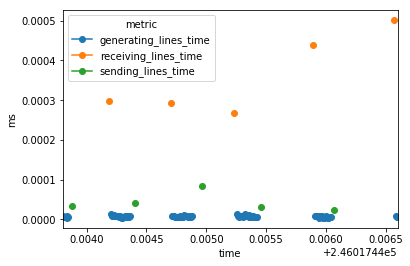

In [3]:
ax = detailed_metrics_blocking.iloc[100:200].plot(marker='o')
ax.set(ylabel='ms')

## Nonblocking

In [4]:
detailed_metrics_nonblocking = collect_detailed_metrics(VowpalWabbitNonBlockingProcess).set_index(['time', 'metric']).unstack().sort_index()
detailed_metrics_nonblocking.columns = detailed_metrics_nonblocking.columns.droplevel(0)

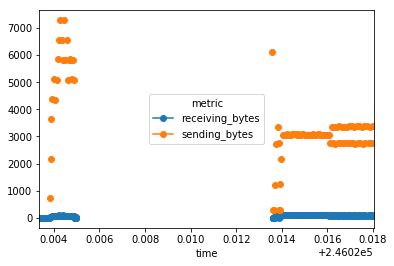

In [5]:
detailed_metrics_nonblocking.iloc[10000:11000][['receiving_bytes', 'sending_bytes']].plot(marker='o')

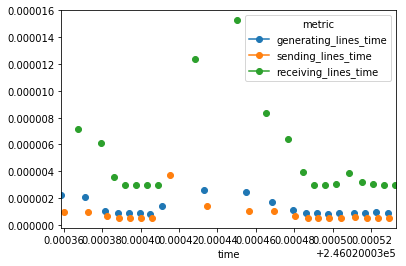

In [6]:
detailed_metrics_nonblocking.iloc[10000:10100][['generating_lines_time', 'sending_lines_time', 'receiving_lines_time']].plot(marker='o')

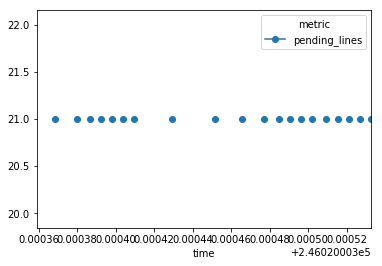

In [7]:
detailed_metrics_nonblocking.iloc[10000:10100][['pending_lines']].plot(marker='o')